In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
import os
import pickle
import operator
import itertools
from collections import defaultdict
import tqdm
import tskit
import numpy as np
import pyslim
import scipy.stats as stats
from scipy import interpolate
from scipy.ndimage import gaussian_filter1d
from sklearn.metrics import mean_absolute_error as MAE
import matplotlib.pyplot as plt
import matplotlib as mpl

from bgspy.models import BGSModel 
from bgspy.genome import Genome
from bgspy.utils import read_centro, BScores, GenomicBins
from bgspy.utils import read_bkgd, midpoint, arg_nearest
from bgspy.utils import bin_chrom, get_files, BScores, exact_index
from bgspy.sim_utils import calc_b_from_treeseqs, load_b_chrom_sims 
from bgspy.theory import bgs_segment, bgs_segment_sc16
from bgspy.classic import BSC16_segment_lazy

2022-09-01 19:58:29.708951: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [4]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.fontset'] = 'cm'
plt.style.use('./buffalo.mplstyle')

# from https://writing.stackexchange.com/questions/21658/what-is-the-image-size-in-scientific-paper-if-indicated-as-a-single-1-5-or-2-c 
# in mm
mm_to_inches = lambda x: 0.0393701 * x
img_size = dict(one = mm_to_inches(90), onehalf = mm_to_inches(140), two = mm_to_inches(190))
asp_ratio = dict(golden = (1 + np.sqrt(5))/2, one=1, two=2)
fig_sizes = {(k, ar): np.round((v, v/asp_ratio[ar]), 4) for k, v in img_size.items() for ar in asp_ratio}
fig_sizes

{('one', 'golden'): array([3.5433, 2.1899]),
 ('one', 'one'): array([3.5433, 3.5433]),
 ('one', 'two'): array([3.5433, 1.7717]),
 ('onehalf', 'golden'): array([5.5118, 3.4065]),
 ('onehalf', 'one'): array([5.5118, 5.5118]),
 ('onehalf', 'two'): array([5.5118, 2.7559]),
 ('two', 'golden'): array([7.4803, 4.6231]),
 ('two', 'one'): array([7.4803, 7.4803]),
 ('two', 'two'): array([7.4803, 3.7402])}

In [5]:
g = Genome('hg38', seqlens_file="../data/annotation/hg38_seqlens.tsv")
g.load_recmap("../data/annotation/hapmap_genetic_map.txt")

ignoring HapMap header...
parsing recmap as HapMap formatted (chrom, end, rate)


## Load Data

### bgspy B maps

In [6]:
pkl_b_file = '../data/bmaps/bgspy/bmap_hg38_sims_10000step_chr10.pkl'
m = BGSModel.load(pkl_b_file)
g = m.genome

bp = m.BpScores
b = m.BScores

In [86]:
bp.B['chr10'].shape

(13381, 6, 7, 1)

### McVicker's `calc_bkgd` 

In [7]:
bkgd_dir = '../data/bmaps/calc_bkgd/'
cached_bkgd1k_file = os.path.join(bkgd_dir, "calc_bkgd_100000.pkl")
mcvb = BScores.load(cached_bkgd1k_file)
mcvb.w, mcvb.t

(array([1.00e-10, 3.16e-10, 1.00e-09, 3.16e-09, 1.00e-08, 3.16e-08]),
 array([0.0001  , 0.000316, 0.001   , 0.00316 , 0.01    , 0.0316  ,
        0.1     ]))

### Simulation Data

`sim_B` is a `.npz` object with mean, variance, and the raw data for all replicates (`X`).

In [60]:
sim_B = np.load('../data/slim_sims/chrombgs_chr10/chrombgs_chr10_thresh0/chrombgs_chr10_thresh0.npz', allow_pickle=True)
mus = sim_B['mu']
shs = sim_B['sh']

In [9]:
# shape of raw data -- last dimension is number of replicates
sim_B['X'].shape

(133798, 6, 7, 100)

To get a sense of the variance across simulation replicates, let's average all replicates and look at how the mean varies across chromosomal space.

In [10]:
mus, shs

(array([1.00e-10, 3.16e-10, 1.00e-09, 3.16e-09, 1.00e-08, 3.16e-08]),
 array([0.0001  , 0.000316, 0.001   , 0.00316 , 0.01    , 0.0316  ,
        0.1     ]))

In [35]:
sim_B['X'].shape

(133798, 6, 7, 100)

Now, for convenience we load the means and standard deviations into `BScores` objects.  

In [75]:
# create midpoints
sims_pos = (sim_B['pos'][1:] + sim_B['pos'][:-1])/2

sims_means = BScores({'chr10': np.log(sim_B['mean'])}, {'chr10': sims_pos}, mus, shs, step=None)
sims_sds = BScores({'chr10': np.log(sim_B['sd'])}, {'chr10': sims_pos}, mus, shs, step=None)

In [202]:
sims = BScores({'chr10': np.log(sim_B['X'])}, {'chr10': sims_pos}, mus, shs, step=None)

In [118]:
sim_means_500kb = sims_means.bin_means(GenomicBins(g.seqlens, 500_000))
sim_means_1Mb = sims_means.bin_means(GenomicBins(g.seqlens, 1_000_000))

sim_sd_500kb = sims_sds.bin_means(GenomicBins(g.seqlens, 500_000))
sim_sd_1Mb = sims_sds.bin_means(GenomicBins(g.seqlens, 1_000_000))


In [206]:
sims_1Mb = sims.bin_means(GenomicBins(g.seqlens, 1_000_000))

In [38]:
list(sim_B.keys())

['mu', 'sh', 'pos', 'X', 'nreps', 'mean', 'sd', 'files']

Note that the simulations are heteroscedastic across $B(x)$, and the level varies across parameters (below).

This could be due to varying levels of polymorphism along the genome — except that where diversity is the lowest (low recombination regions), we'd expect fewer segregating sites, and thus *higher* variance; here we see the opposite.

Thus, the BGS process (under strong-ish selection) is reducing the variance in coalescent times.

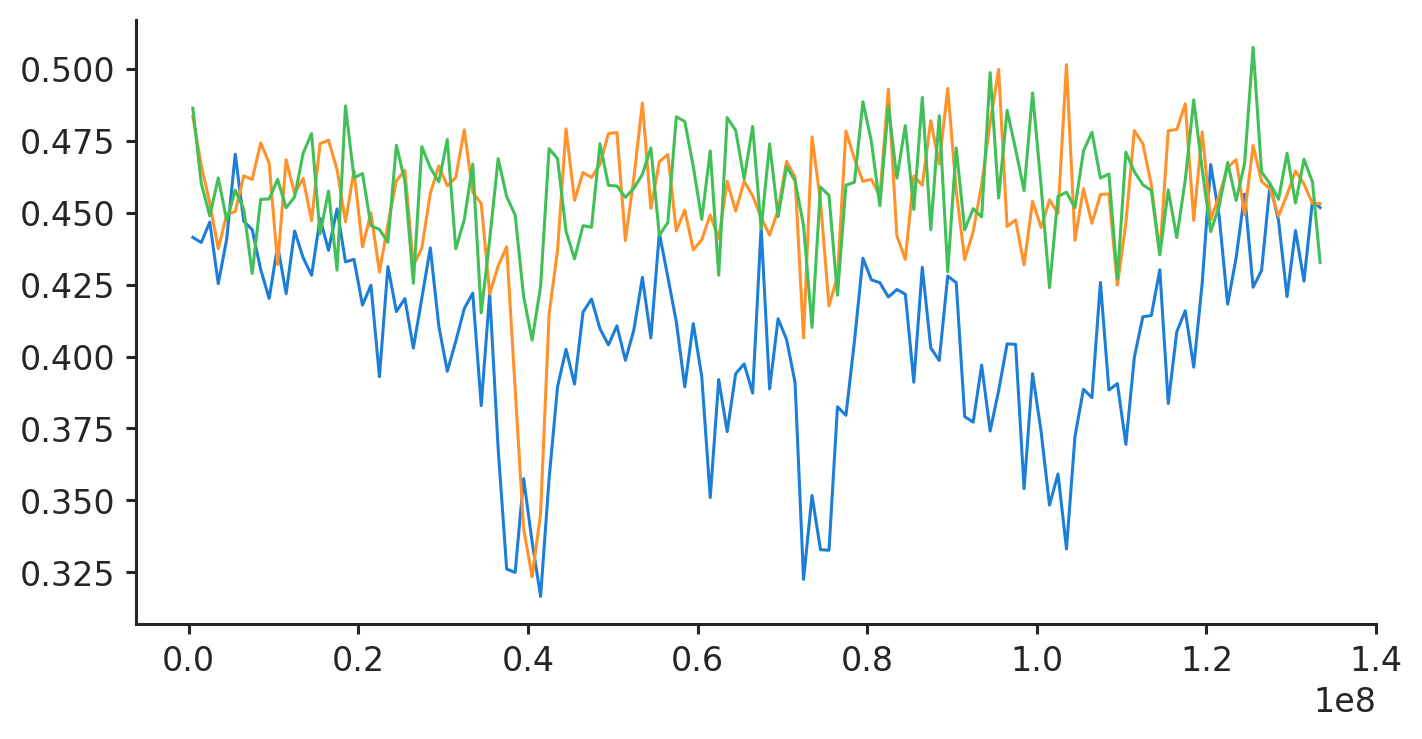

In [201]:
plt.plot(*sim_sd_1Mb['chr10', 1e-8, 1e-2])
plt.plot(*sim_sd_1Mb['chr10', 1e-8, 1e-4])
plt.plot(*sim_sd_1Mb['chr10', 1e-9, 1e-4])

## At what scale do we see the BGS signal?

In [55]:
sims_pos = (sim_B['pos'][1:] + sim_B['pos'][:-1])/2
sim_1 = BScores({'chr10': np.log(sim_B['X'][..., 0])}, {'chr10': sims_pos}, mus, shs, step=None)

In [56]:
sim_1_1Mb = sim_1.bin_means(GenomicBins(g.seqlens, 1_000_000))

In [159]:
from bgspy.data import GenomeData

hg38_gd = GenomeData(g)
hg38_gd.load_counts_dir('../data/h1kg/hg1k_counts/')
hg38_gd.load_neutral_masks('../data/annotation/neutral_phastcons_genes_with_introns.bed.gz')
hg38_gd.load_accessibile_masks('../data/annotation/no_centro.bed')

hg38_bins, hg38_pi = hg38_gd.bin_pi(width=1e6, filter_neutral=True, filter_accessible=True)

In [182]:
bp.t

array([0.0001  , 0.000316, 0.001   , 0.00316 , 0.01    , 0.0316  ,
       0.1     ])

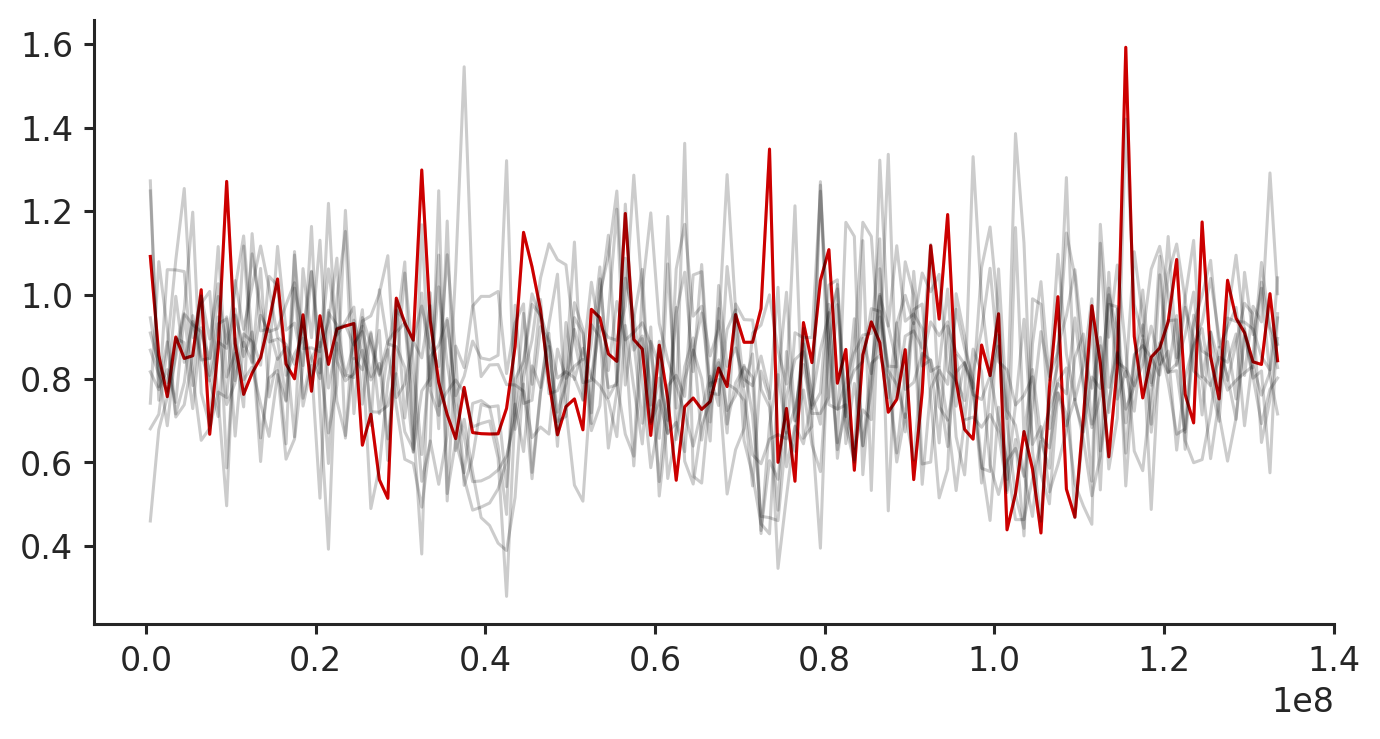

In [224]:
x, y = sim_1_1Mb.pairs('chr10', 1e-8, 1e-2)
_ = plt.plot(x, y, c='r', label='sim mean', zorder=2)

xx, yy = sims_1Mb.pairs('chr10', 1e-8, 1e-2)
for i in range(10):
    plt.plot(xx, yy[:, i], c='k', alpha=0.2)

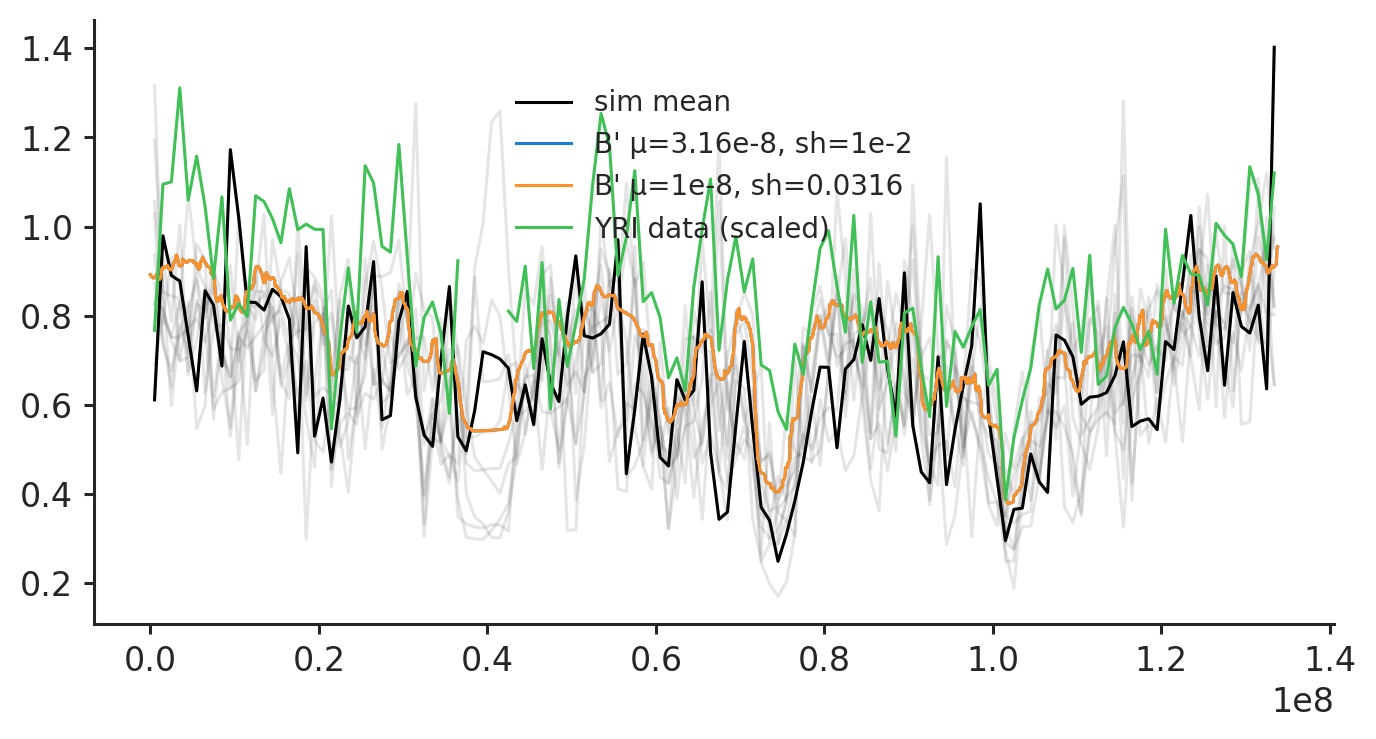

In [220]:
x, y = sim_1_1Mb.pairs('chr10', 3.16e-8, 1e-2)
_ = plt.plot(x, y, c='k', label='sim mean')

xx, yy = sims_1Mb.pairs('chr10', 3.16e-8, 1e-2)
for i in range(10):
    plt.plot(xx, yy[:, i], c='k', alpha=0.1)
plt.plot(*bp.pairs('chr10', 3.16e-8, 1e-2), label="B' μ=3.16e-8, sh=1e-2")
plt.plot(*bp.pairs('chr10', 3.16e-8, 1e-2), label="B' μ=1e-8, sh=0.0316")
dx, dy = hg38_pi['chr10'].pairs
plt.plot(dx, dy*0.63e3, label="YRI data (scaled)")
plt.legend()
#plt.ylim(0.7, 1.1)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial


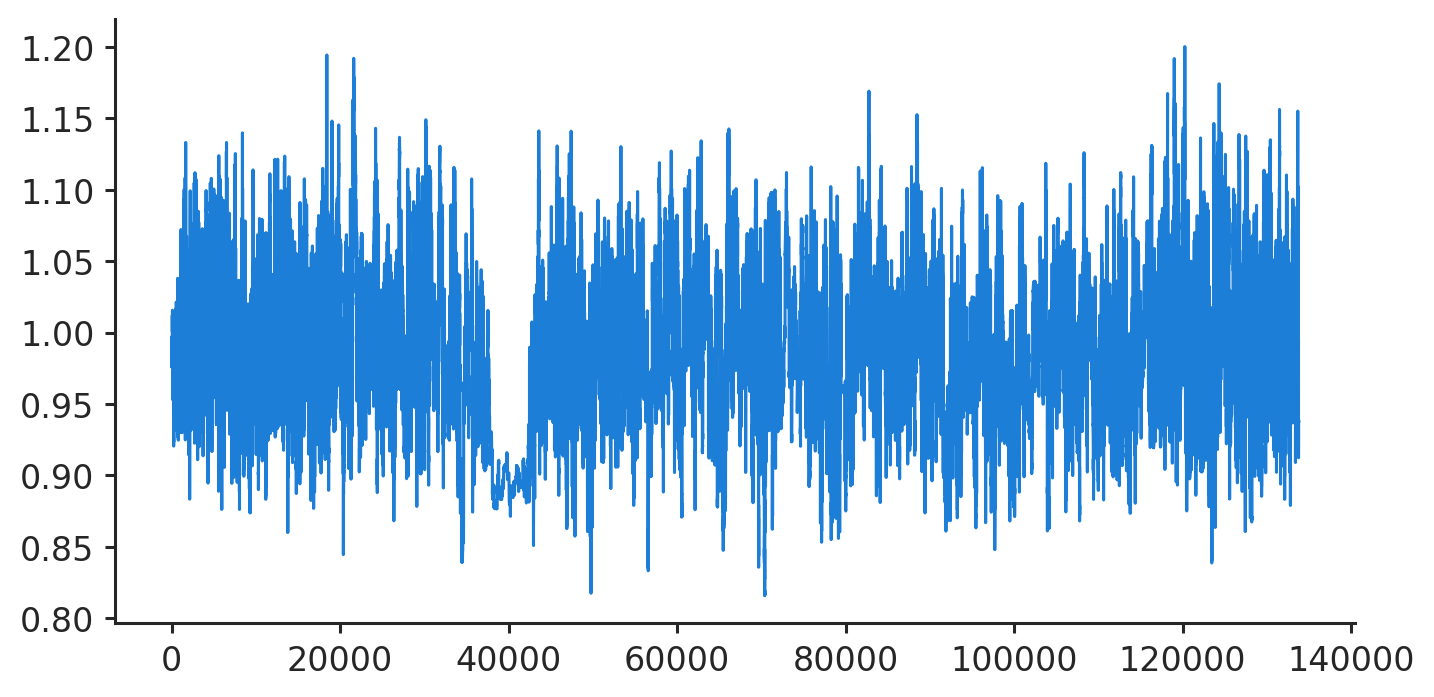

In [11]:
plt.plot(sim_B['X'].mean(axis=3)[:, 2, 5])

## Experiments with Dxy

(30000000.0, 40000000.0)

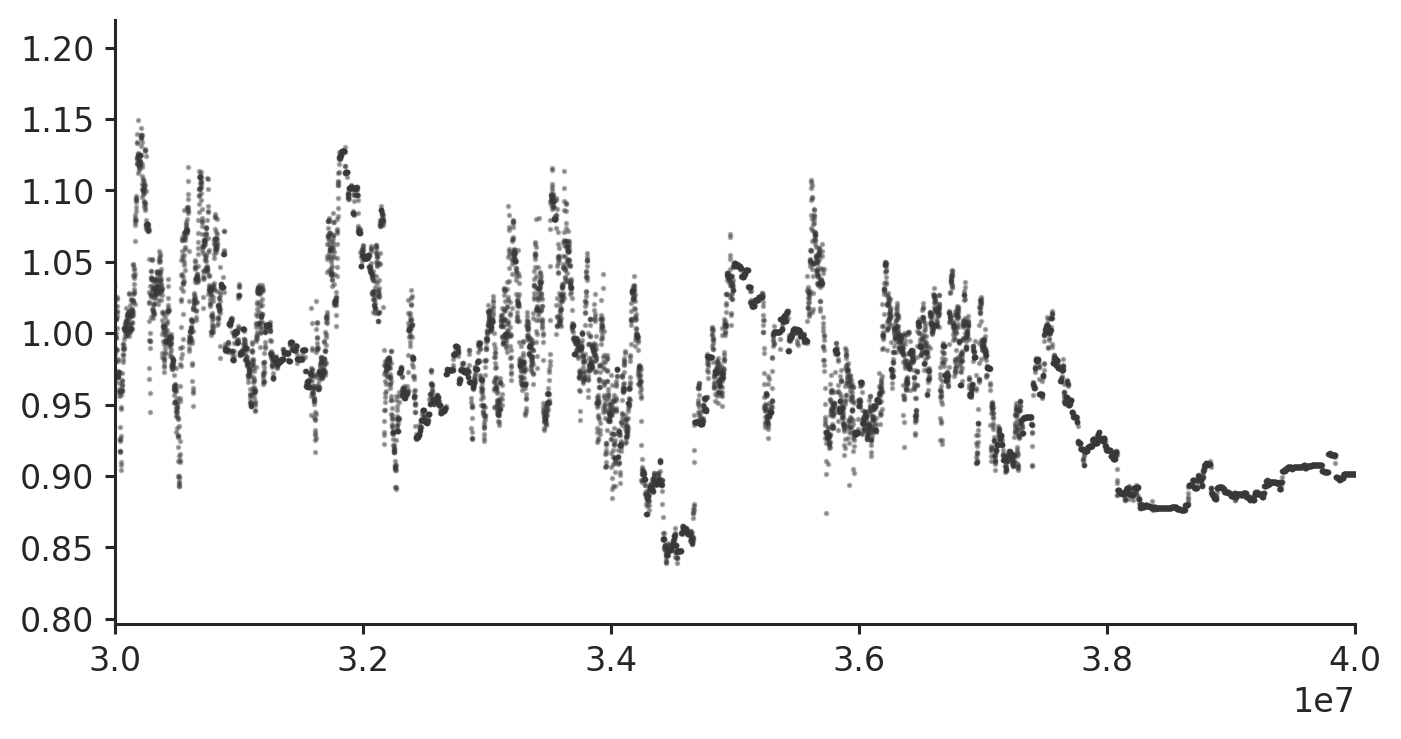

In [14]:
plt.scatter(sims_pos, sim_B['X'].mean(axis=3)[:, 2, 5], c='0.22', alpha=0.4, s=1)
plt.xlim(0.3e8, 0.4e8)

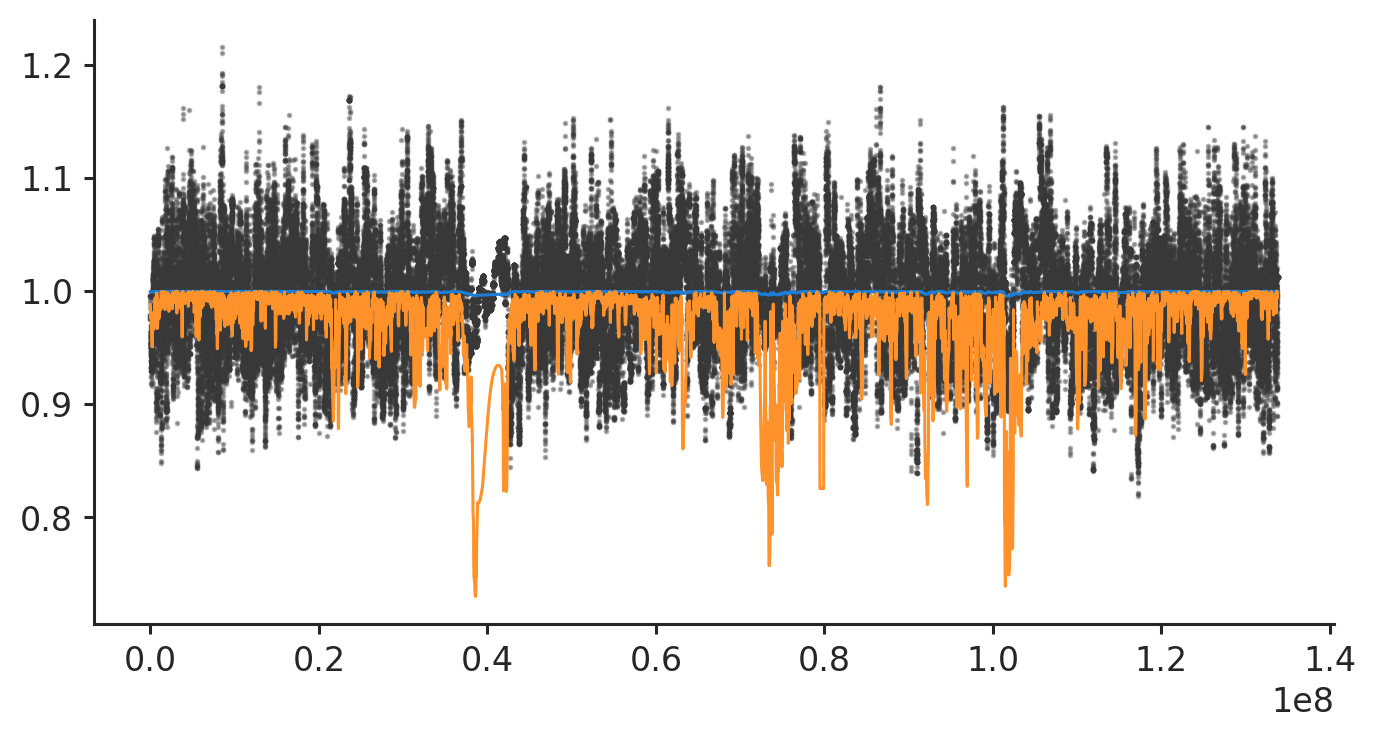

In [15]:
plt.scatter(*sims_means.pairs('chr10', 1e-9, 1e-3), c='0.22', alpha=0.4, s=1)
plt.plot(*bp.pairs('chr10', 1e-9, 1e-4))
plt.plot(*b.pairs('chr10', 1e-9, 1e-4))
#plt.xlim(0.1e8, 0.4e8)


In [16]:
import pandas as pd

In [17]:
dalt = pd.read_csv('../data/all_pidxy_win-size_1000000_merged-mask_True_state_all_curr_all.tsv', sep='\t')
dalt['midpoint'] = (dalt.start + dalt.end)/2
dalt_pi = dalt.loc[(dalt.stat == 'pi') & (dalt.spp1 == 'homo') & (dalt.spp2 == 'homo')]
dalt_dxy = dalt.loc[(dalt.stat == 'dxy') & (dalt.spp2 == 'homo') &  
                    ((dalt.spp1 == 'weastern_chimp') | (dalt.spp1 == 'eastern_chimp'))]

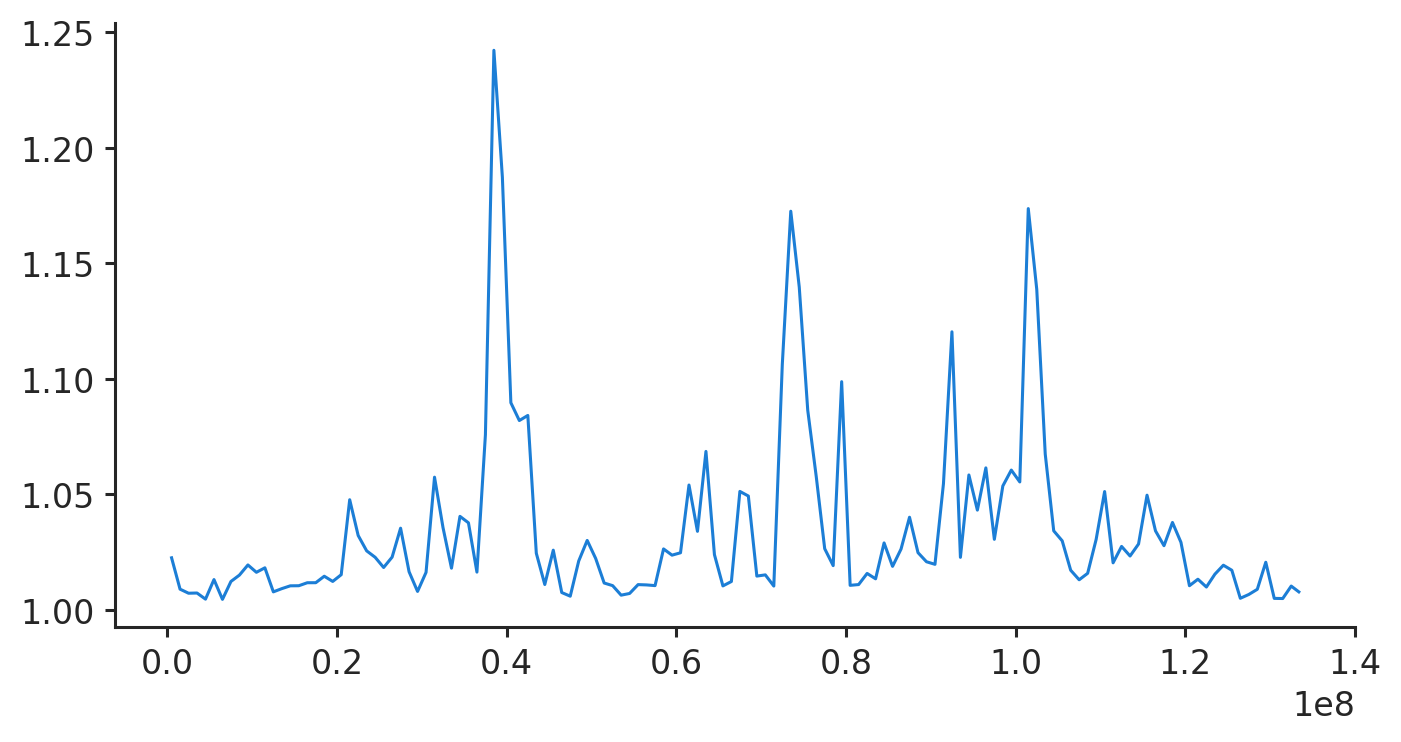

In [18]:
bpy_1Mb = bp.bin_means(GenomicBins(g.seqlens, 1_000_000))
b_1Mb = b.bin_means(GenomicBins(g.seqlens, 1_000_000))

x, bpy = bpy_1Mb.pairs('chr10', 1e-9, 1e-4)
x, by = b_1Mb.pairs('chr10', 1e-9, 1e-4)
plt.plot(x, bpy/by)

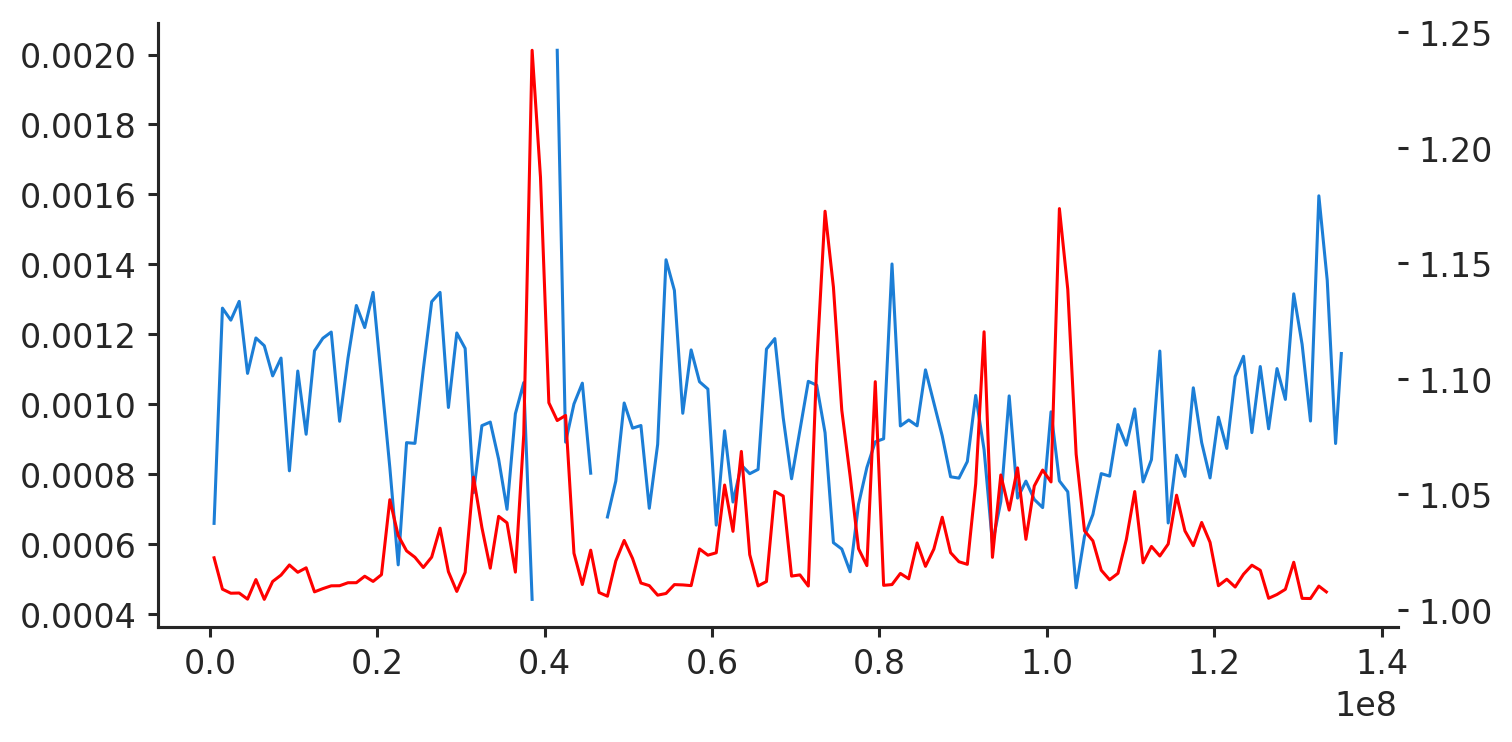

In [20]:
ddd = dalt_pi.loc[dalt_pi.chr == 'chr10']
fig, ax = plt.subplots()
ax.plot(ddd.midpoint, ddd.value)
ax2 = ax.twinx()
ax2.plot(x, bpy/by, c='r')

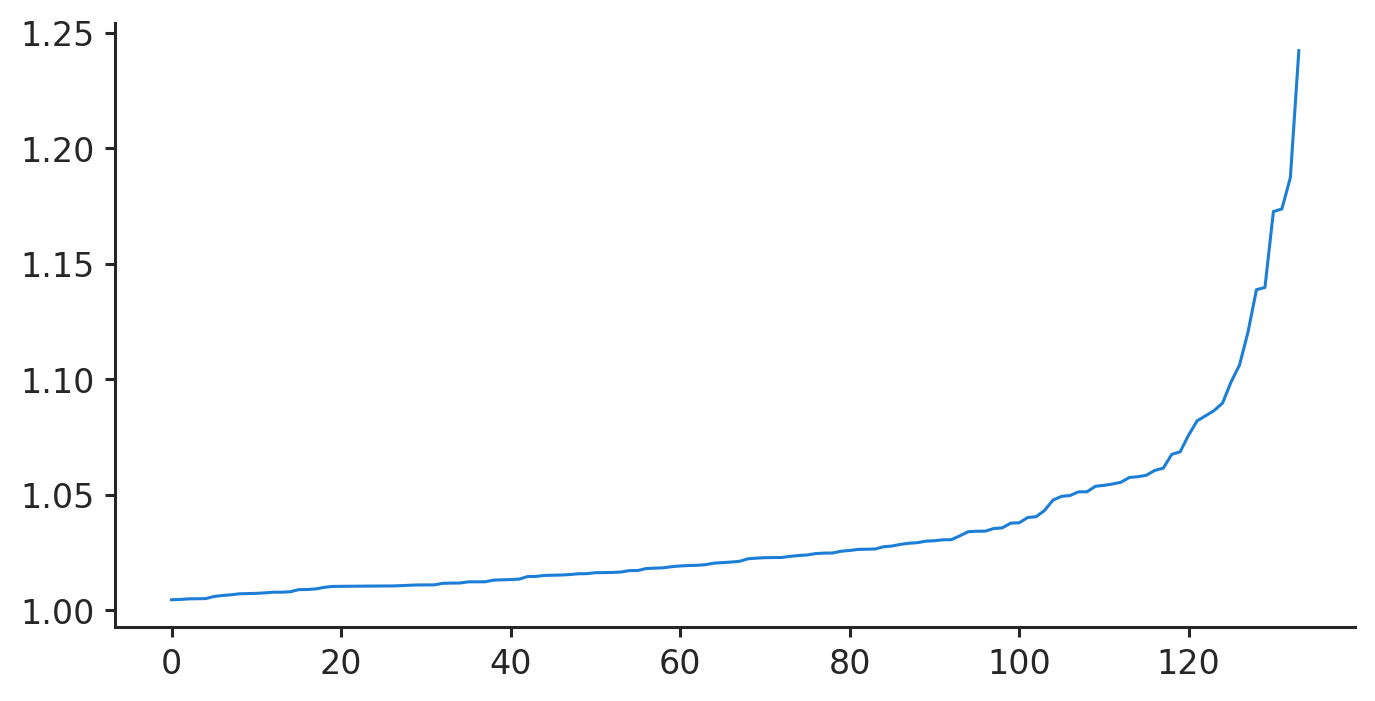

In [21]:
plt.plot(np.sort(bpy/by))

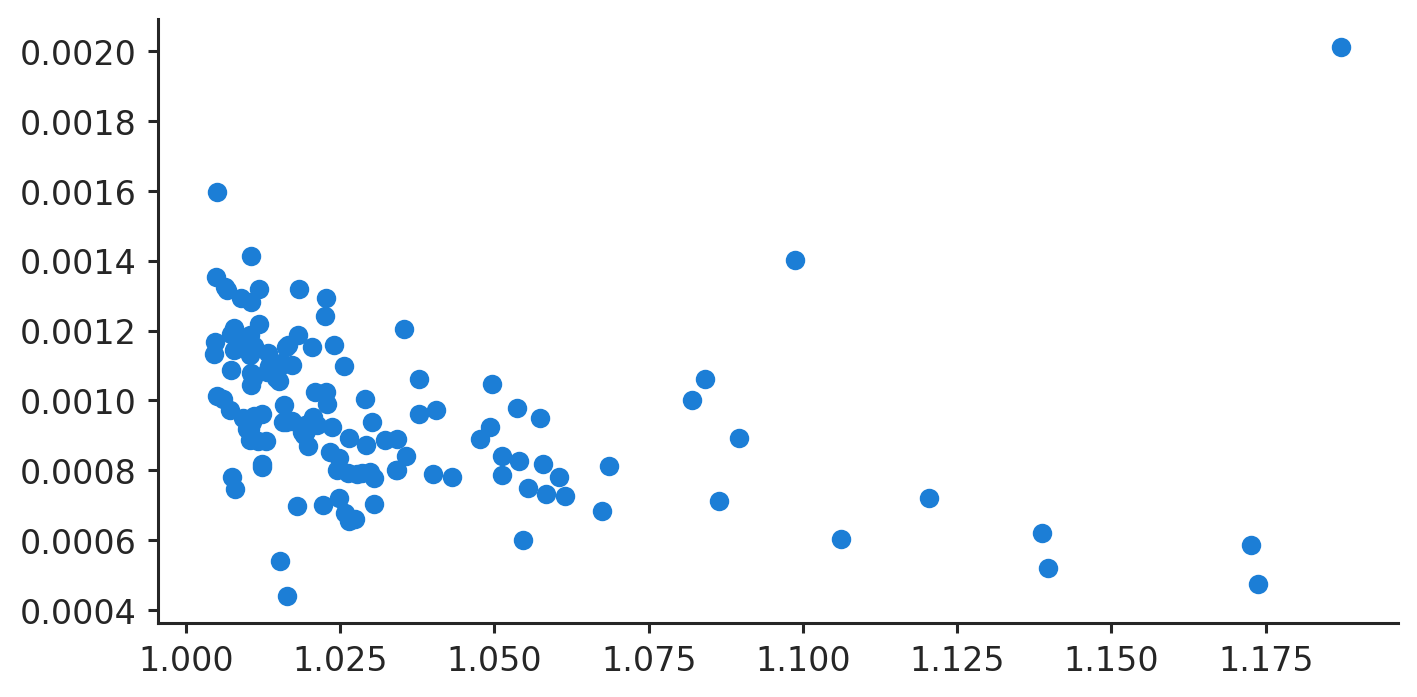

In [22]:
plt.scatter(bpy/by, ddd.value[2:])

## B Map Comparisons

These B maps show something interesting: the ratio of noise to signal varies with the strength of selection and mutation. There is only a very narrow parameter range where the signal of genomic selective structure comes through.


We can describe the **background selection signal intensity** as the $\mathrm{E}(B)(x)$ and the variance over simulation replicates.


In [61]:
def comparison_plot(w, t, b, bp, sims, clcbg=None, sims_sds=None):
    x, y = sims['chr10', w, t]
    lines = plt.plot(x, y, label='sims', zorder=10)
    plt.plot(*b.pairs('chr10', w, t), label='B')
    plt.plot(*bp.pairs('chr10', w, t), label="B'", linestyle='dashed')
    if sims_sds is not None:
        x, sd = sims_sds['chr10', w, t]
        plt.fill_between(x, y - sd, y + sd, alpha=0.4, 
                         linewidth=0, color=lines[0].get_color())
    if clcbg is not None:
        plt.plot(*clcbg.pairs('chr10', w, t), label="calc_bkgd")
    plt.legend()
    plt.title(f"μ={w}, t={t}")

In [62]:
m.w, m.t

(array([1.00e-10, 3.16e-10, 1.00e-09, 3.16e-09, 1.00e-08, 3.16e-08]),
 array([0.0001  , 0.000316, 0.001   , 0.00316 , 0.01    , 0.0316  ,
        0.1     ]))

Let's look at a case that's approximately: high-ish mutation (1e-8 mutation, 10% of all SNPs are selected against with $s = 0.001$).

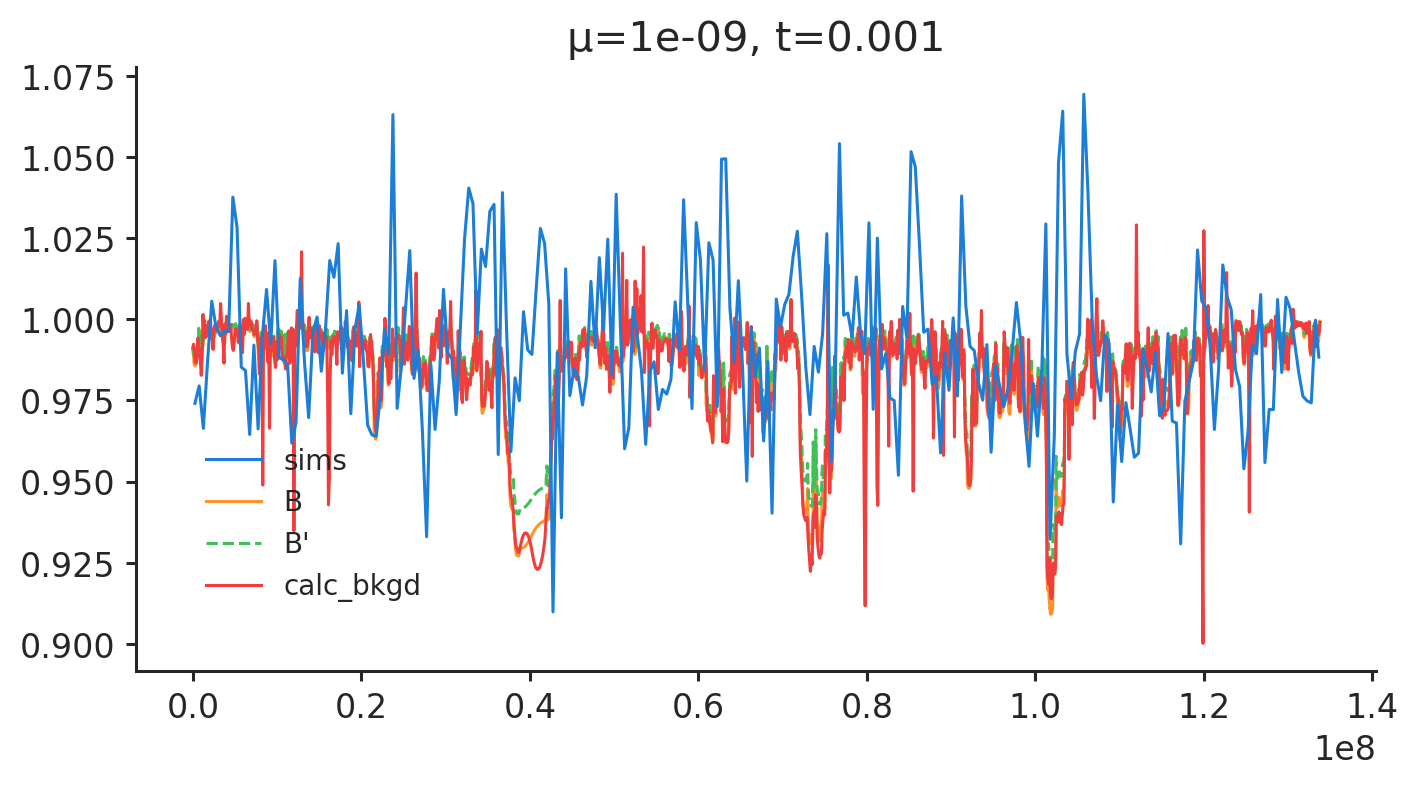

In [63]:
comparison_plot(1e-9, 0.001, b, bp, sims=sim_means_500kb, clcbg=mcvb)

Now, with even stronger selection:

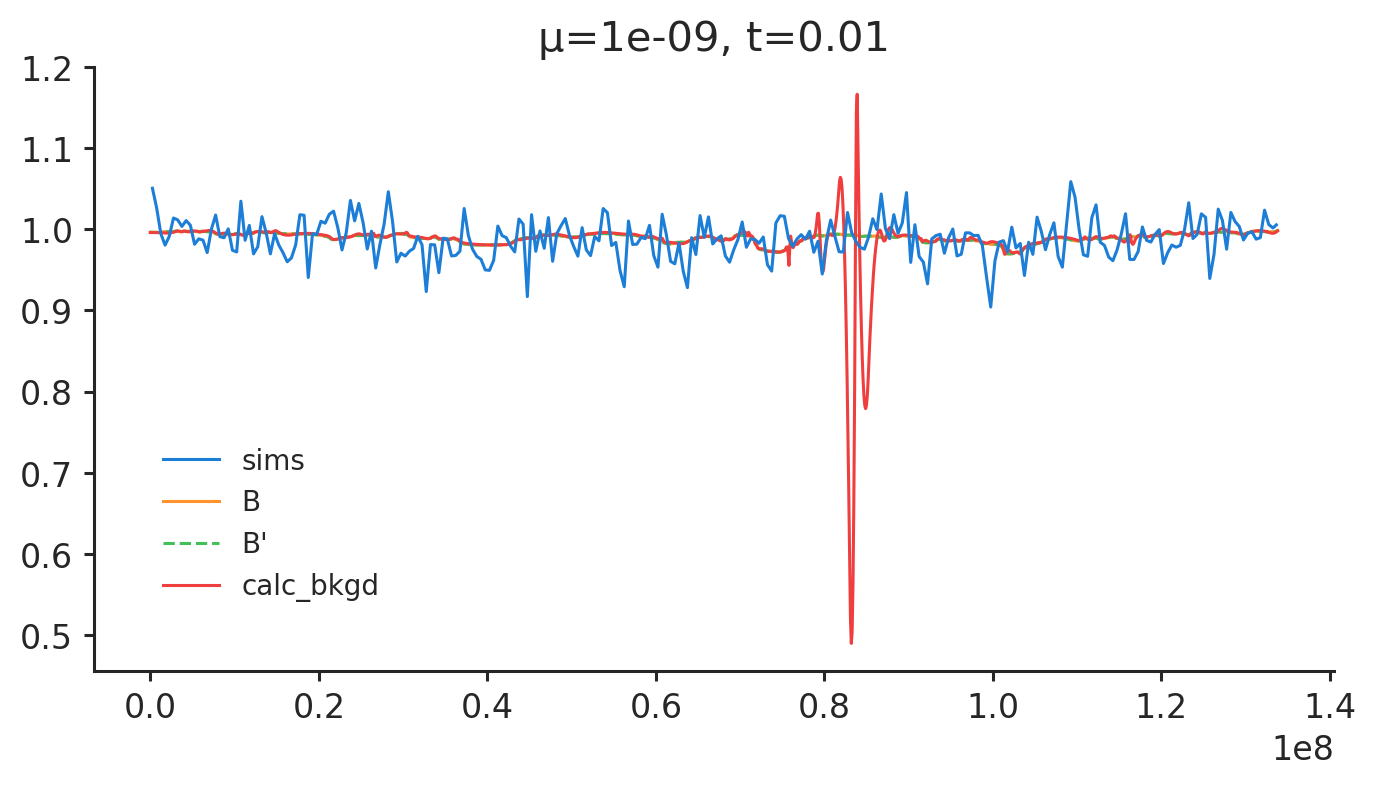

In [64]:
comparison_plot(m.w[2], m.t[4], b, bp, sims=sim_means_500kb, clcbg=mcvb)

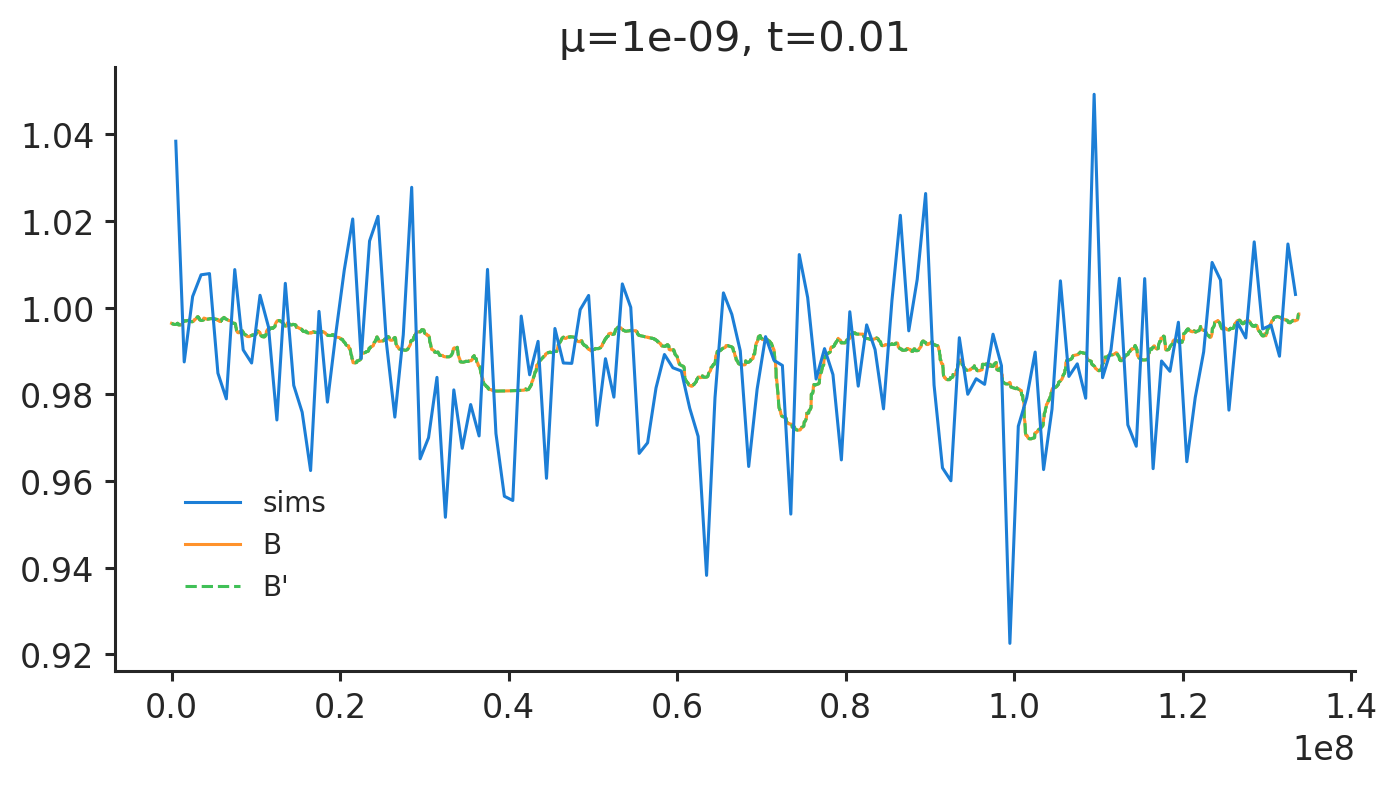

In [66]:
comparison_plot(m.w[2], m.t[4], b, bp, sims=sim_means_1Mb)

In [67]:
3.16e-9 / 1e-8

0.316

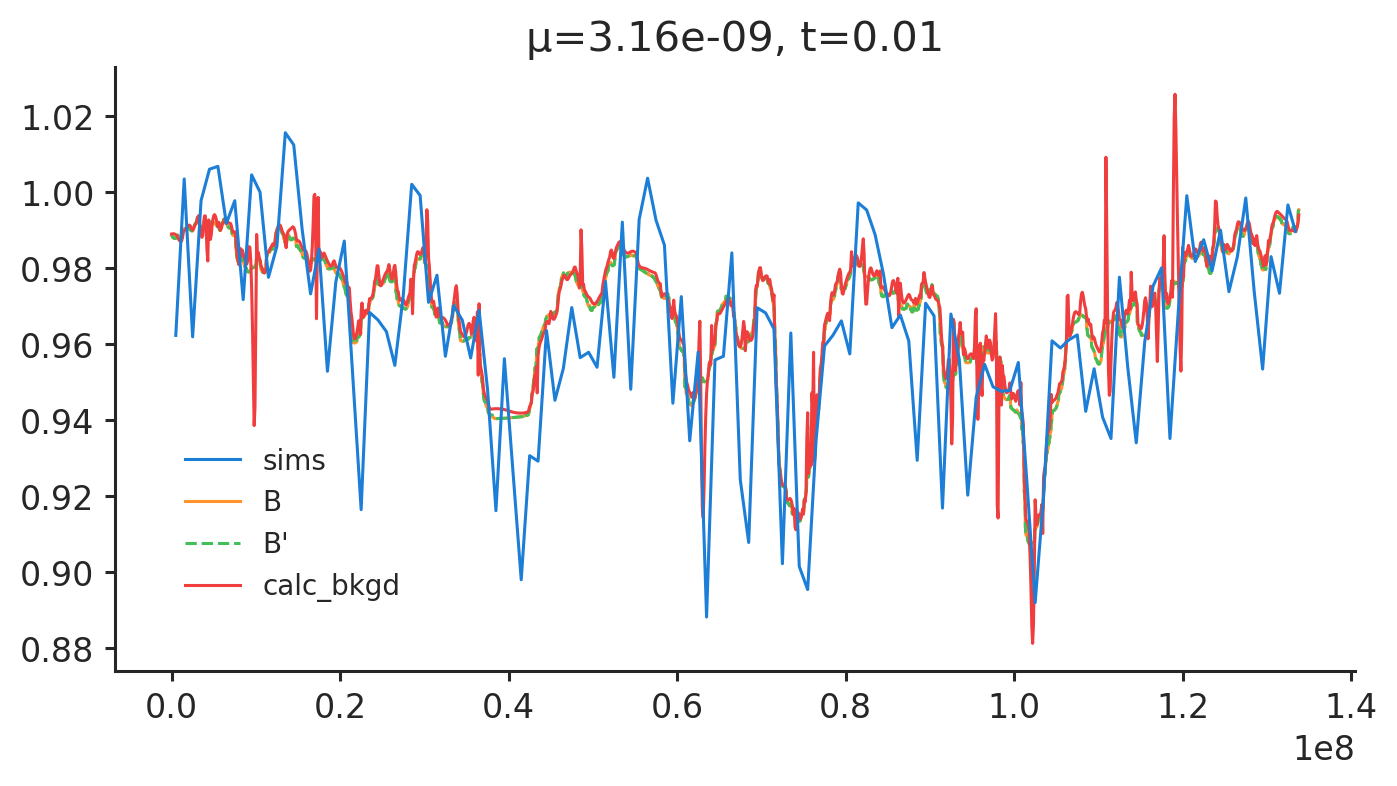

In [51]:
comparison_plot(m.w[3], m.t[4], b, bp, sims=sim_means_1Mb, clcbg=mcvb)
plt.

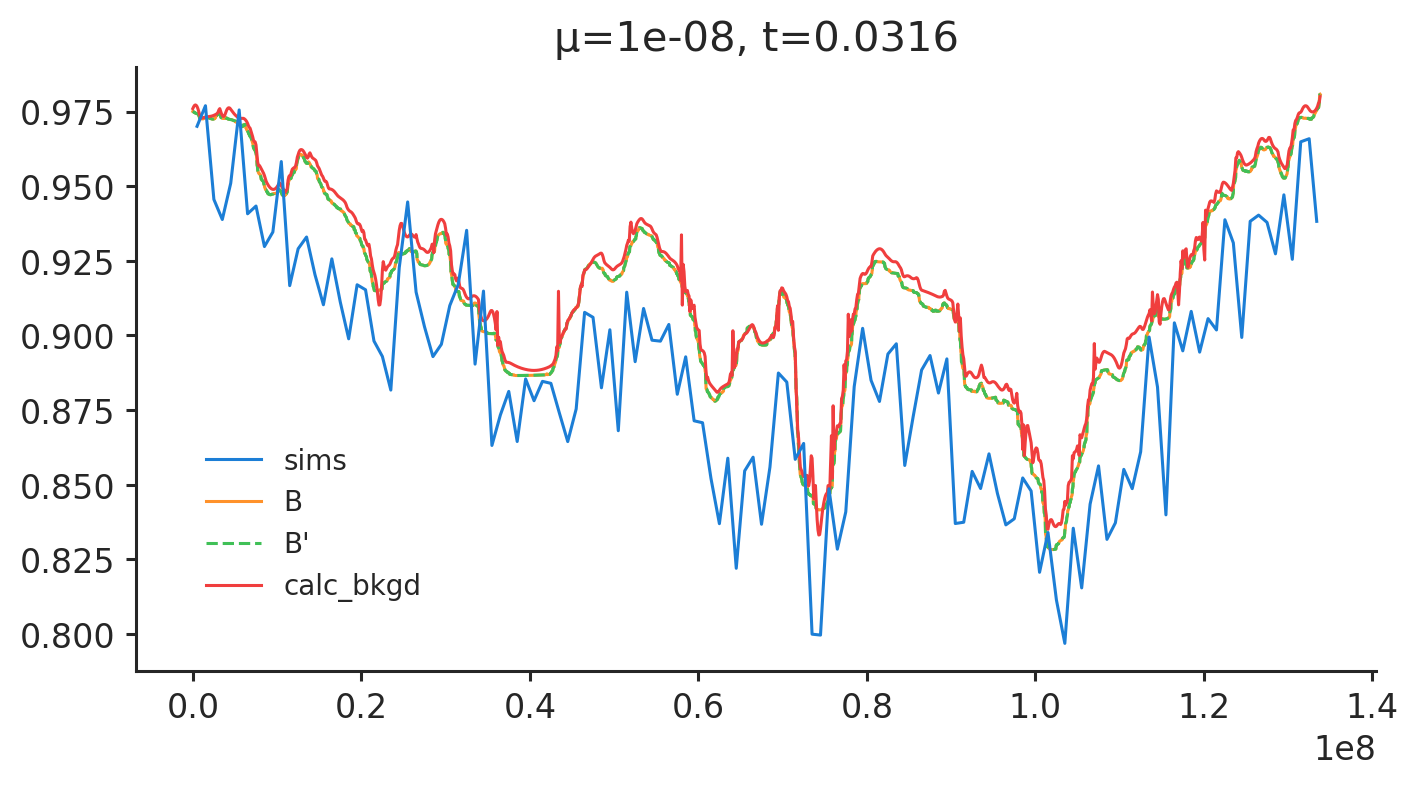

In [34]:
comparison_plot(m.w[4], m.t[5],  b, bp, sims=sim_means_1Mb, clcbg=mcvb)

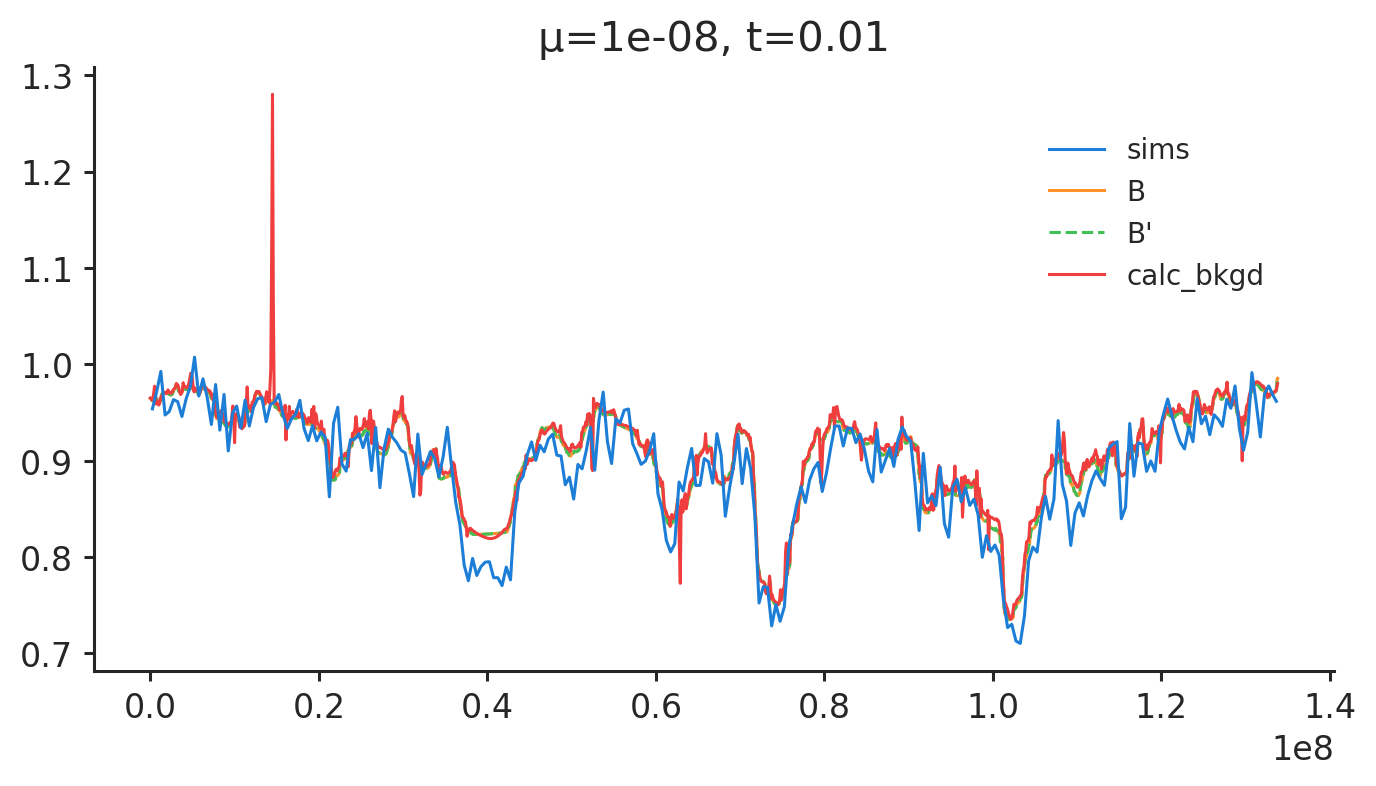

In [30]:
comparison_plot(m.w[4], m.t[4], b, bp, sims=sim_means_500kb, clcbg=mcvb)

(0.7, 1.1)

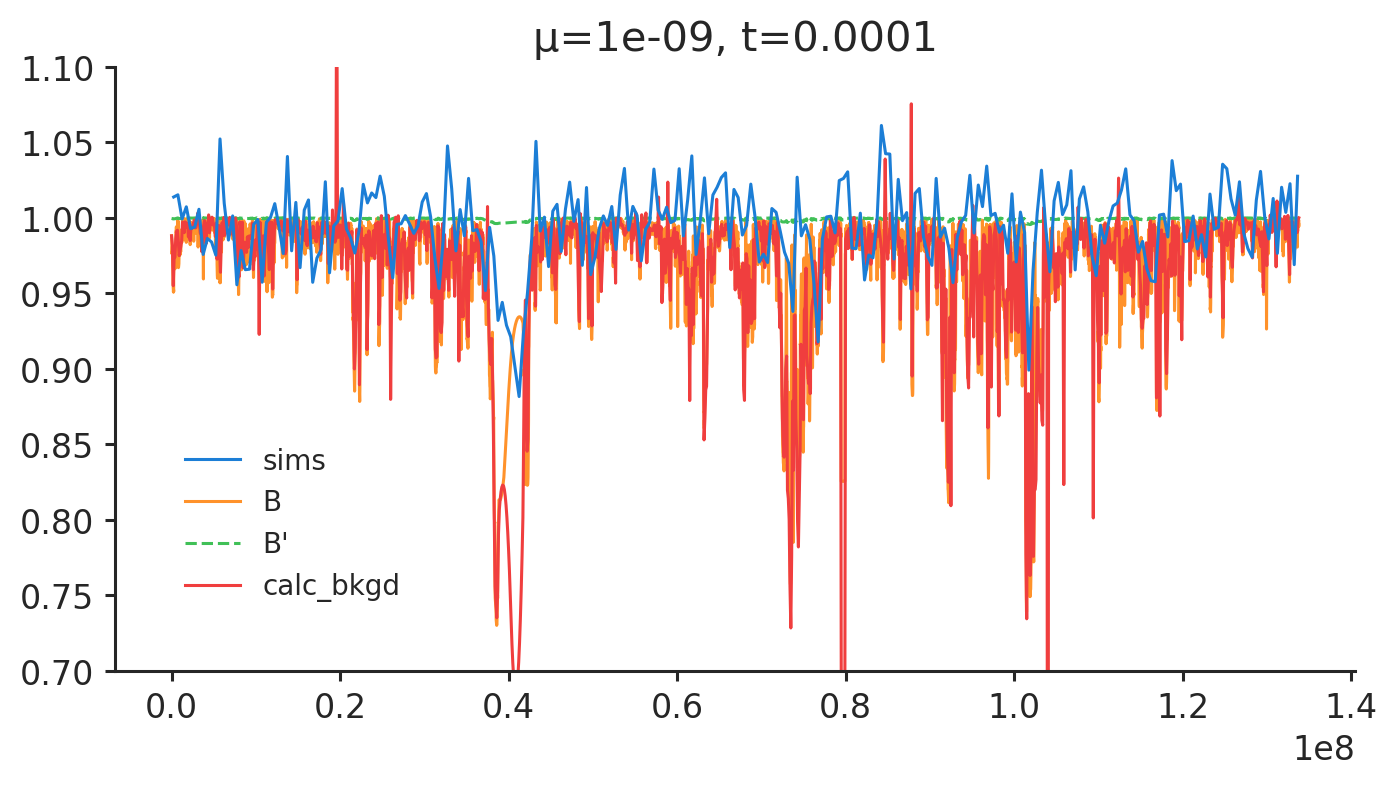

In [146]:
comparison_plot(1e-9, 0.0001, b, bp, sims=sim_means_500kb, clcbg=mcvb)
plt.ylim(0.7, 1.1)

## Analysis of Background Selection Signal Intensity

I calculate this as $R^2$ between the simulation means (across 100 replicates) and the $B'$ values.

In [139]:
from bgspy.likelihood import R2

def signal_intensity(w, t, b, sims):
    #nx, nw, nt, nf = b.shape
    bx, by = b.pairs('chr10', w, t)
    x, y = sims['chr10', w, t]
    assert bx.size == x.size, f"bin mismatch: {bx.size}, {x.size}"
    return R2(by, y)

signal_intensity(1e-8, 1e-4, bp.bin_means(GenomicBins(g.seqlens, 1_000_000)), sim_means_1Mb)


0.5166499396962909

In [140]:
R2s = []
ws, ts = [], []
for w, t in itertools.product(m.w, m.t):
    r2 = signal_intensity(w, t, bp.bin_means(GenomicBins(g.seqlens, 1_000_000)), sim_means_1Mb)
    R2s.append(r2)
    ws.append(w)
    ts.append(t)
    
df = pd.DataFrame(dict(w=ws, t=ts, R2=R2s))

In [141]:
df.head()

,w,t,R2
0,1.000000e-10,0.000100,0.207030
1,1.000000e-10,0.000316,-0.416210
2,1.000000e-10,0.001000,0.038939
3,1.000000e-10,0.003160,0.052138
4,1.000000e-10,0.010000,-0.201848


Text(0.5, 0, 'mutation rate')

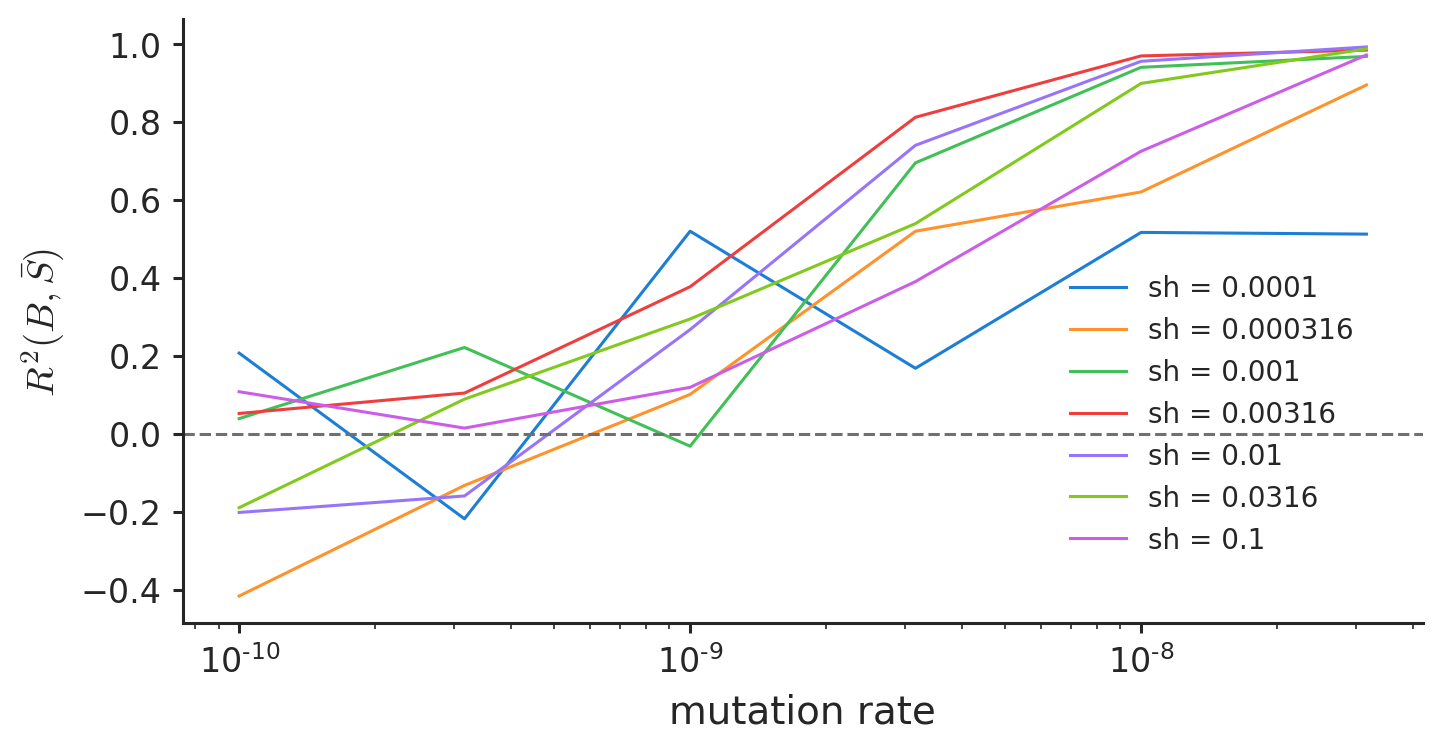

In [145]:
for t in m.t:
    ds = df.loc[df.t == t]
    plt.plot(ds.w, ds.R2, label=f"sh = {t}")
plt.semilogx()
plt.legend()
plt.axhline(0, linestyle='dashed', c='0.44')
plt.ylabel('$R^2(B, \\bar{S})$')
plt.xlabel('mutation rate')

In [ ]:
plt.plot(simm.w[4], m.t[5]

## Simulations

building interpolators...		done.
building interpolators...		done.


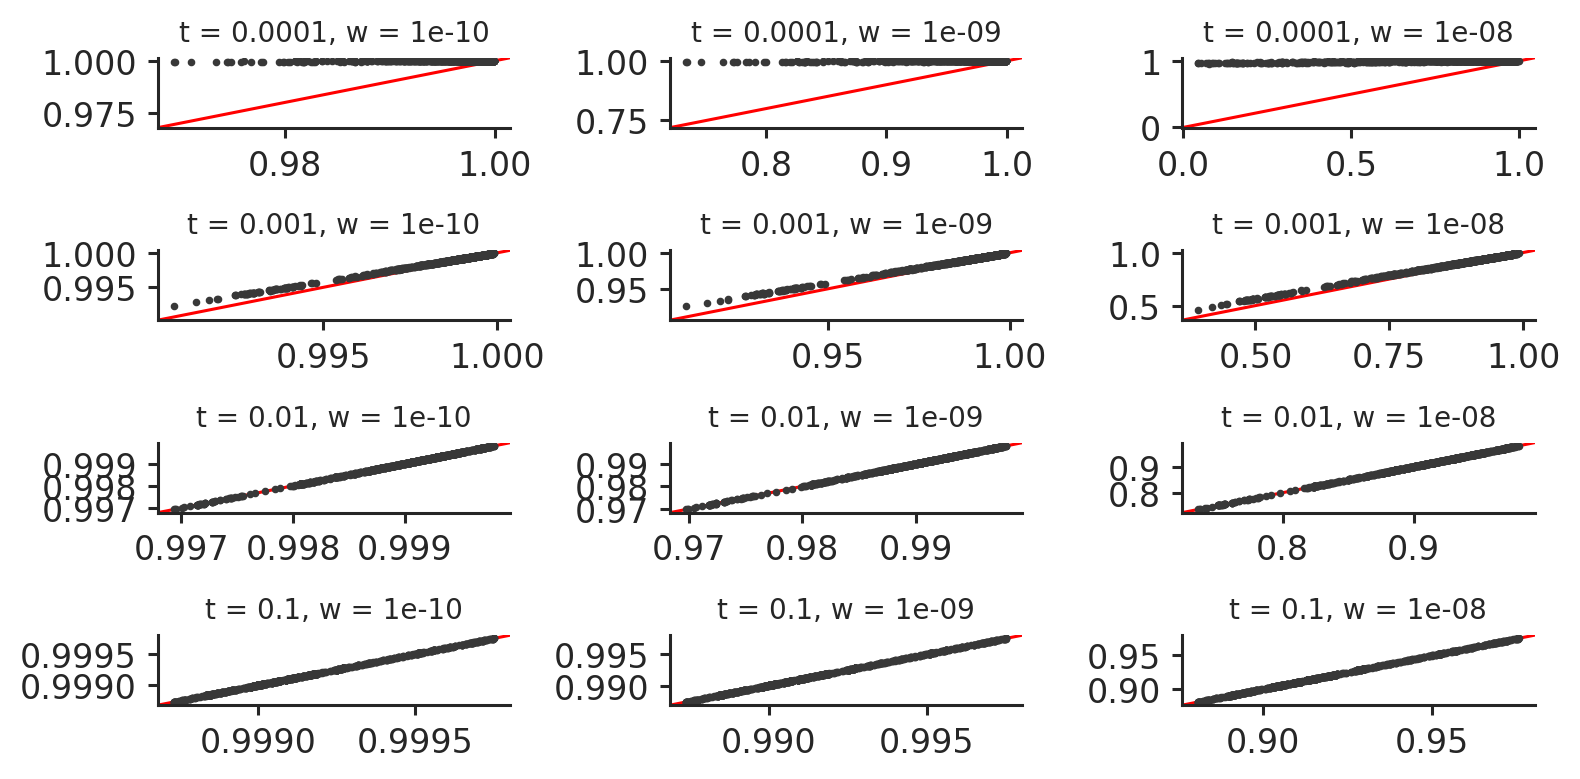

In [35]:
sh = 0.1
mu = 2.e-10

facet_mus = np.array([1.e-10, 1.e-9, 1.e-8])
facet_shs = np.array([0.0001 , 0.001, 0.01, 0.1])


chrom = 'chr10'
pos = np.random.choice(sims_pos, 1000)

nc, nr = len(facet_mus), len(facet_shs)
f, ax = plt.subplots(ncols=nc, nrows=nr)

for i, j in itertools.product(range(nc), range(nr)):
    mu = facet_mus[i]
    sh = facet_shs[j]
    x = np.exp(b.B_at_pos('chr10', pos))[exact_index(mu, mus), exact_index(sh, shs)]
    y = np.exp(bp.B_at_pos('chr10', pos))[exact_index(mu, mus), exact_index(sh, shs)]

    ax[j, i].scatter(x, y, s=3, c='0.22')
    o = min(np.min(x), np.min(y))
    ax[j, i].axline((o, o), slope=1, c='r', zorder=-1)
    ax[j, i].set_title(f"t = {sh}, w = {mu}", size=10)
    
plt.tight_layout()

In [41]:
def B_bins(x, y, nbins):
    bm = stats.binned_statistic(x, y, np.nanmean, bins=nbins)
    mps = (bm.bin_edges[1:] + bm.bin_edges[:-1])/2
    return mps, bm.statistic

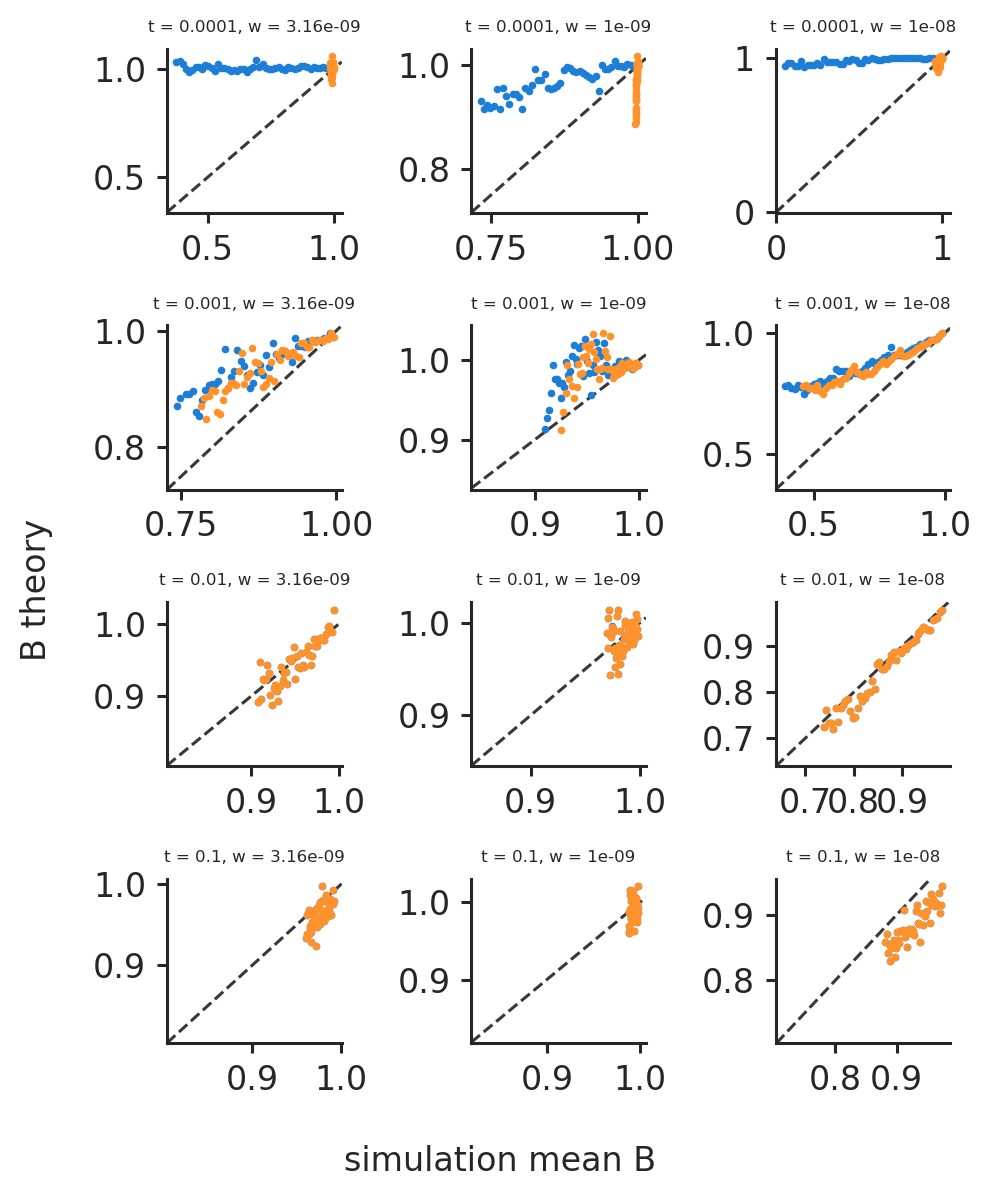

In [43]:
facet_mus = np.array([3.16e-09, 1.e-9, 1.e-8])
facet_shs = np.array([0.0001 , 0.001, 0.01, 0.1])


chrom = 'chr10'
n = 10000
nbins = 50
idx = np.random.randint(0, len(sims_pos), n)
pos = sims_pos[idx]

nc, nr = len(facet_mus), len(facet_shs)
f, ax = plt.subplots(ncols=nc, nrows=nr, figsize=(5, 6))

for i, j in itertools.product(range(nc), range(nr)):
    mu = facet_mus[i]
    sh = facet_shs[j]
    y = np.exp(b.B_at_pos('chr10', pos))[exact_index(mu, mus), exact_index(sh, shs)].squeeze()
    ya = np.exp(bp.B_at_pos('chr10', pos))[exact_index(mu, mus), exact_index(sh, shs)].squeeze()
    x = sims_means['chr10', mu, sh][1][idx]
    
    ax[j, i].scatter(*B_bins(y, x, nbins), s=3)
    ax[j, i].scatter(*B_bins(ya, x, nbins), s=3)
    
    o = min(np.min(x), np.min(y))
    ax[j, i].axline((o, o), slope=1, c='0.22', linestyle='dashed', zorder=-1)
    ax[j, i].set_title(f"t = {sh}, w = {mu}", size=6)
    o = 0
    #ax[j, i].set_xlim(o, 1.01)
    #ax[j, i].set_ylim(o, 1.01)
    #if i == 0:
    #    ax[j, i].set_ylabel("B theory")
    #if j == nr:
    #    ax[j, i].set_xlabel("simulation mean B")

f.supxlabel('simulation mean B')
f.supylabel('B theory')

plt.tight_layout()

In [ ]:
facet_mus = np.array([3.16e-09, 1.e-9, 1.e-8])
facet_shs = np.array([0.0001 , 0.001, 0.01, 0.1])


chrom = 'chr10'
n = 1000
idx = np.random.randint(0, len(sim_pos), n)
pos = sim_pos[idx]

nc, nr = len(facet_mus), len(facet_shs)
f, ax = plt.subplots(ncols=nc, nrows=nr, sharex='col', sharey='row', figsize=(4, 5))

all_sim, all_bsc = [], []
all_s, all_mu = [], []
all_pos = []

for i, j in itertools.product(range(nc), range(nr)):
    mu = facet_mus[i]
    sh = facet_shs[j]
    y = np.exp(b.B_at_pos('chr10', pos))[exact_index(mu, mus), exact_index(sh, shs)]
    ya = np.exp(bp.B_at_pos('chr10', pos))[exact_index(mu, mus), exact_index(sh, shs)]
    x = sims_means['chr10', mu, sh][1][idx]
    
    ax[j, i].scatter(x, ya, s=3, c=g.recmap.lookup('chr10', pos), norm=mpl.colors.LogNorm())
    all_s.extend([sh]*len(x))
    all_mu.extend([mu]*len(x))
    all_sim.extend(x.tolist())
    all_pos.extend(pos.tolist())
    all_bsc.extend(ya.tolist())
    #ax[j, i].scatter(x, ya, s=3)

    o = min(np.min(x), np.min(y))
    ax[j, i].axline((o, o), slope=1, c='0.22', linestyle='dashed', zorder=-1)
    ax[j, i].set_title(f"t = {sh}, w = {mu}", size=6)
    o = 0
    #ax[j, i].set_xlim(o, 1.01)
    #ax[j, i].set_ylim(o, 1.01)
    #if i == 0:
    #    ax[j, i].set_ylabel("B theory")
    #if j == nr:
    #    ax[j, i].set_xlabel("simulation mean B")


f.supxlabel('simulation mean B')
f.supylabel('B theory')

plt.tight_layout()